<h1 style='background:#F9EEEC; border:0; color: #EA7B67'><center>Meta Pseudo Label</center></h1>

**This Kernel translated into Korean. If you not Korean, Check : <a href="https://www.kaggle.com/code/hengck23/playground-for-meta-pseudo-label">LINK</a>**

**Reference LINK[Pseudo Label] : <a href="https://www.kaggle.com/code/kalelpark/pseudo-labeling-for-korean">LINK</a>**

<h1 style='background:#F9EEEC; border:0; color: #EA7B67'><center>TABLE OF CONTENTS</center></h1>

[1. Load Dataset](#1)
    
[2. for Experiment Model](#2)    

[3. Display Function](#3)        

[4. Experiment(only train)](#4)  

[5. Experiment (Train Label + UnLabel)](#5)    

[6. Experiment (Meta Pseudo Label)](#6)  

[7. Experiment (Meta Pseudo Label Exact2)](#7)

<h1 style='background:#F9EEEC; border:0; color: #EA7B67'><center>START</center></h1>

<a id="1"></a>
# **<span style="color:#4686C8;">Load Dataset</span>**

**Meta Pseudo Label를 위해, Dummy Dataset을 생성하여, 활용하도록 하겠습니다.**

**Sklearn Meta Data 생성 관련하여, 참고하시기 바랍니다. : <a href="https://datascienceschool.net/03%20machine%20learning/09.02%20%EB%B6%84%EB%A5%98%EC%9A%A9%20%EA%B0%80%EC%83%81%20%EB%8D%B0%EC%9D%B4%ED%84%B0%20%EC%83%9D%EC%84%B1.html">LINK</a>**


In [14]:
import numpy as np 
from sklearn import datasets

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from matplotlib import pyplot as plt
%matplotlib inline

num_unlabel = 500
num_train = 3
num_valid = 100

# n_samples = 1000 | (x, y)로 주어짐
x_unlabel, y_unlabel =  datasets.make_moons(n_samples = num_unlabel * 2, shuffle = False, 
                                            noise = 0.2, random_state = 123)

x_train, y_train = datasets.make_moons(n_samples = num_train * 2, shuffle = False, 
                                       noise = 0.2, random_state = 456)

x_valid, y_valid = datasets.make_moons(n_samples = num_valid * 2, shuffle = False, 
                                       noise = 0.2, random_state = 789)

grid = torch.meshgrid(torch.linspace(-3, 3, steps = 100), torch.linspace(-3, 3, steps =100))
grid = torch.stack(grid, -1)
grid = grid.reshape(-1, 2).cuda()

In [15]:
x_unlabel.shape, y_unlabel.shape, x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

((1000, 2), (1000,), (6, 2), (6,), (200, 2), (200,))

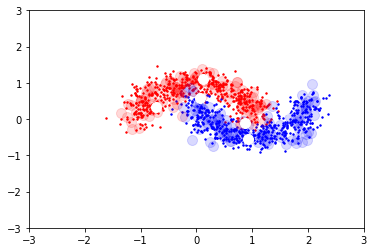

In [16]:
def show_data():
    plt.scatter(x_unlabel[:num_unlabel, 0], x_unlabel[:num_unlabel, 1], s = 2, alpha = 1, facecolors = 'r')
    plt.scatter(x_unlabel[num_unlabel:, 0], x_unlabel[num_unlabel:, 1], s = 2, alpha = 1, facecolors = 'b')
    
    plt.scatter(x_valid[:num_valid, 0], x_valid[:num_valid, 1], s = 100, alpha = 0.15, c = 'r')
    plt.scatter(x_valid[num_valid:, 0], x_valid[num_valid:, 1], s = 100, alpha = 0.15, c = 'b')
    
    plt.scatter(x_train[:num_train, 0], x_train[:num_train, 1], s = 100, alpha = 1, c = 'w')
    plt.scatter(x_train[num_train:, 0], x_train[num_train:, 1], s = 100, alpha = 1, c = 'w')

    plt.ylim([-3, 3])
    plt.xlim([-3, 3])

show_data()
plt.show()

<a id="2"></a>
# **<span style="color:#4686C8;">For Experiment Model</span>**

**Meta Pseudo Label 실험을 위한, Teacher Modle, Student Model을 생성하도록 하겠습니다.**


In [17]:
# ---- Residual : Reference ResNet ----
class Residual1d(nn.Module):
    def __init__(self, dim):
        super().__init__()
        
        self.linear1 = nn.Linear(dim, dim)
        self.bn1 = nn.BatchNorm1d(dim)
        self.linear2 = nn.Linear(dim, dim)
        self.bn2 = nn.BatchNorm1d(dim)
        self.act = nn.SiLU(inplace = True)
        
    def forward(self, x):
        residual = x
        x = self.bn1(self.linear1(x))
        x = self.act(x)
        x = self.bn2(self.linear2(x))
        x = self.act(x)
        x = residual + x
        
        return self.act(x)

# ---- Net : Reference ResNet ----
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.stem = nn.Sequential(
            nn.Linear(2, 128),
            nn.BatchNorm1d(128),
            nn.SiLU(inplace = True),
        )
        
        self.feature = nn.ModuleList([
            Residual1d(128) for i in range(3)
        ])
        
        self.logit = nn.Linear(128, 1)
        
    def forward(self, x):
        x = self.stem(x)
        x = self.feature[0](x)
        x = self.feature[1](x)
        x = self.feature[2](x)
        
        logit = self.logit(x).reshape(-1)
        return logit

<a id="3"></a>
# **<span style="color:#4686C8;">Display Function</span>**

**Test & Valid 시, Data의 분포를 파악하고, 실험하기 위해, function을 생성합니다.**


In [20]:
def show_predict_space(net):
    net = net.eval()
    predict = torch.sigmoid(net(grid))
    predict = predict.data.cpu().numpy()
    g = grid.data.cpu().numpy()
    plt.scatter(g[:, 0], g[:,1], c = predict)
    show_data()
    
def print_validate(net):
    x = torch.from_numpy(x_valid).float().cuda()
    y = torch.from_numpy(y_valid).float().cuda()
    
    net = net.eval()
    logit = net(x)
    loss = F.binary_cross_entropy_with_logits(logit, y)
    
    predict = (torch.sigmoid(logit)>0.5).long()
    predict = predict.data.cpu().numpy()
    correct = (predict==y_valid).mean()
    
    print('Valid BCE Loss : ', loss.item())
    print('Valid Accuracy : ', correct)

<a id="4"></a>
# **<span style="color:#4686C8;">Experiment (Only Train)</span>**

**오로지 Train만을 진행합니다.**

<hr>

**Valid BCE Loss :  0.6749110817909241**

**Valid Accuracy :  0.635**


labelled only
Valid BCE Loss :  0.6749110817909241
Valid Accuracy :  0.635


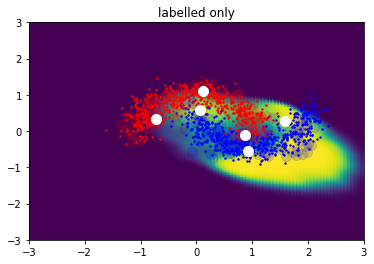

In [21]:
if 1:
    l_x = torch.from_numpy(x_train).float().cuda()
    l_y = torch.from_numpy(y_train).float().cuda()
    
    net = Net().cuda()
    optimizer = optim.SGD(net.parameters(),lr=0.001, momentum=0.9)
    
    for iteration in range(200):
        logit = net(l_x)
        loss = F.binary_cross_entropy_with_logits(logit,l_y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
        #print('\r', iteration, loss.item(), end='', flush=True)
    print('')
    print('labelled only')
    print_validate(net)
    show_predict_space(net)
    plt.title('labelled only')
    plt.show()

<a id="5"></a>
# **<span style="color:#4686C8;">Experiment (Train Label + UnLabel)</span>**

<hr>

**Valid BCE Loss :  0.16552287340164185**

**Valid Accuracy :  0.94**

**Ps, UnLabeldata도 학습했으므로, 성능이 엄청 좋게 나올 수 밖에 없습니다. (실제로는 이러한 학습이 불가능합니다.)**


Upper bound
Valid BCE Loss :  0.16552287340164185
Valid Accuracy :  0.94


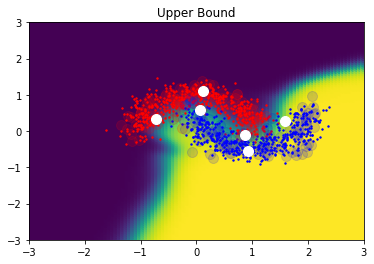

In [9]:
if 1:
    l_x = torch.from_numpy(x_train).float().cuda()
    l_y = torch.from_numpy(y_train).float().cuda()
    
    net = Net().cuda()
    optimizer = optim.SGD(net.parameters(), lr = 1e-3, momentum = 0.9)
    
    for iteration in range(200):
        random_sample = np.random.choice(num_unlabel*2, 16).tolist()
        u_x = torch.from_numpy(x_unlabel[random_sample]).float().cuda()
        u_y = torch.from_numpy(y_unlabel[random_sample]).float().cuda()
        
        l_logit = net(l_x)
        u_logit = net(u_x)
        
        loss = (F.binary_cross_entropy_with_logits(l_logit,l_y)+ F.binary_cross_entropy_with_logits(u_logit,u_y)) /2
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print('')
    print('Upper bound')
    print_validate(net)
    show_predict_space(net)
    plt.title('Upper Bound')
    plt.show()

<a id="6"></a>
# **<span style="color:#4686C8;">Experiment (Meta Pseudo Label)</span>**

<hr>

**metal pseudo label : student**

**Valid BCE Loss :  0.4567197263240814**

**Valid Accuracy :  0.735**

**metal pseudo label : teacher**

**Valid BCE Loss :  0.47291067242622375**

**Valid Accuracy :  0.715**

metal pseudo label : student
Valid BCE Loss :  0.4567197263240814
Valid Accuracy :  0.735


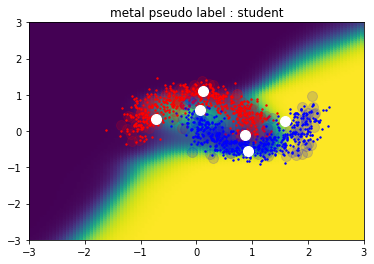

metal pseudo label : teacher
Valid BCE Loss :  0.47291067242622375
Valid Accuracy :  0.715


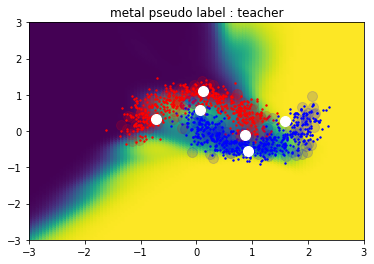

In [37]:
if 1:
    l_x = torch.from_numpy(x_train).float().cuda()
    l_y = torch.from_numpy(y_train).float().cuda()
    
    teacher = Net().cuda()
    student = Net().cuda()
    
    t_optimizer = optim.SGD(teacher.parameters(),lr=0.0005, momentum=0.9)
    s_optimizer = optim.SGD(student.parameters(),lr=0.0005, momentum=0.9)
     
    for iteration in range(200):
        # t : Teacher, s : Student
        # l : label, u : unlabel
        teacher.train()
        student.train()
        t_optimizer.zero_grad()
        s_optimizer.zero_grad()
        
        random_sample = np.random.choice(num_unlabel * 2, 16).tolist()
        u_x = torch.from_numpy(x_unlabel[random_sample]).float().cuda()
        
        # prepare other Input
        # note these is detached, i.e not used for backprop
        s_l_logit = student(l_x)
        s_l_loss = F.binary_cross_entropy_with_logits(s_l_logit.detach(), l_y)
        
        t_u_logit = teacher(u_x)
        pseudo_y = (t_u_logit.detach()>0).float()
        # ---
        
        # train student : update student using pseudo label data only
        s_u_logit = student(u_x)
        s_u_loss  = F.binary_cross_entropy_with_logits(s_u_logit, pseudo_y)
        s_u_loss.backward()
        s_optimizer.step()
        
        # train teacher : update teacher using Pseudo label data student change in loss
        s_l_logit_new = student(l_x)
        s_l_loss_new  = F.binary_cross_entropy_with_logits(s_l_logit_new.detach(), l_y)
        change = s_l_loss_new - s_l_loss
        
        t_l_logit = teacher(l_x)
        t_l_loss = F.binary_cross_entropy_with_logits(t_l_logit, l_y)
        t_mpl_loss  = change * F.binary_cross_entropy_with_logits(t_u_logit, pseudo_y)
        
        (t_l_loss+t_mpl_loss).backward()
        t_optimizer.step()
    
    print('metal pseudo label : student')
    print_validate(student)
    show_predict_space(student)
    plt.title('metal pseudo label : student')
    plt.show()
    
    print('metal pseudo label : teacher')
    print_validate(teacher)
    show_predict_space(teacher)
    plt.title('metal pseudo label : teacher')
    plt.show()

<a id="7"></a>
# **<span style="color:#4686C8;">Experiment (Meta Pseudo Label Exact2)</span>**

<hr>

**metal pseudo label (exact) : student**

**Valid BCE Loss :  0.3233928680419922**

**Valid Accuracy :  0.805**

**metal pseudo label (exact): teacher**

**Valid BCE Loss :  0.3697725534439087**

**Valid Accuracy :  0.75**

metal pseudo label (exact) : student
Valid BCE Loss :  0.3233928680419922
Valid Accuracy :  0.805


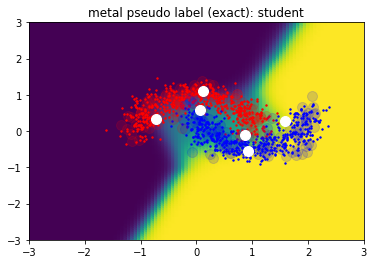

metal pseudo label (exact): teacher
Valid BCE Loss :  0.3697725534439087
Valid Accuracy :  0.75


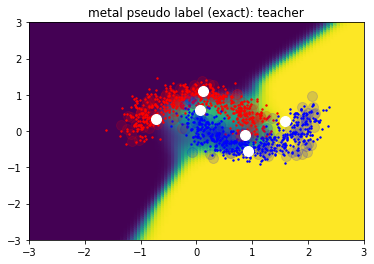

In [38]:
if 1:
    l_x = torch.from_numpy(x_train).float().cuda()
    l_y = torch.from_numpy(y_train).float().cuda()
    
    
    teacher = Net().cuda()
    student = Net().cuda()
    t_optimizer = optim.SGD(teacher.parameters(),lr=0.001, momentum=0.9)
    s_optimizer = optim.SGD(student.parameters(),lr=0.001, momentum=0.9)
    
    for iteration in range(200):
        # subscript: t,s : teacher,student
        # subscript: l,u : label,unlabel
        
        teacher.train()
        student.train()
        t_optimizer.zero_grad()
        s_optimizer.zero_grad()
        
        random_sample = np.random.choice(num_unlabel*2,16).tolist()
        u_x = torch.from_numpy(x_unlabel[random_sample]).float().cuda()
        
        
        #prepare other input
        #note these is detached, i.e. not used for backprop
        #s_l_logit = student(l_x)
        #s_l_loss = F.binary_cross_entropy_with_logits(s_l_logit.detach(), l_y)
        
        t_u_logit = teacher(u_x)
        pseudo_y =  torch.sigmoid(t_u_logit) #t_u_logit>0).float()
        #------
        
        
        
        #train student : update student using pesudo label data only
        s_u_logit = student(u_x)
        s_u_loss  = F.binary_cross_entropy_with_logits(s_u_logit, pseudo_y,reduction='none')
        s_u_loss  = s_u_loss[torch.abs(pseudo_y-0.5)>0.45].mean()
        s_u_loss.backward()
        s_optimizer.step()
        
        
        #train teacher : update teacher using pesudo label data student change in loss
        s_l_logit_new = student(l_x)
        s_l_loss_new  = F.binary_cross_entropy_with_logits(s_l_logit_new, l_y)
        t_mpl_loss    = s_l_loss_new
        
        t_l_logit = teacher(l_x)
        t_l_loss = F.binary_cross_entropy_with_logits(t_l_logit, l_y)
        
        
        (t_l_loss+t_mpl_loss).backward()
        #(t_mpl_loss).backward()
        t_optimizer.step()
        
       
        #print(iteration, s_u_loss.item(), t_l_loss.item(), t_mpl_loss.item())
    #-------------------------------
    print('metal pseudo label (exact) : student')
    print_validate(student)
    show_predict_space(student)
    plt.title('metal pseudo label (exact): student')
    plt.show()
    
    print('metal pseudo label (exact): teacher')
    print_validate(teacher)
    show_predict_space(teacher)
    plt.title('metal pseudo label (exact): teacher')
    plt.show()